In [156]:
import pandas as pd
import plotly.express as px

In [157]:
import re
import random
random.seed(42)

## 0. Number of Free Parameters

In [158]:
V = 11228
n = 6

m = 100
h = 60

V * (1 + n*m + h) + h * (1 + (n-1)*m)

7451768

## 0. Context

The aim of the notebook is to replicate NNLM (`Neural Network Language Model`) by Bengio et al. 

**Objective**

1. Nth word, given n-1 words in sequence
2. Understand how word feature looks like for similar words like cat, dog


**Assumption**

1. Word prediction is happening within a sentence, this implies `.` acts as `End of Sentence` Token

## 1. Downloading Data

In [159]:
import nltk
from nltk.corpus import brown,wordnet

In [160]:
len(brown.sents())

57340

## 2. Creating Data Set from `brown` corpus


> Total Sentences is 57340, and each sentences will be taken as stand alone unit for creating input-target pair 

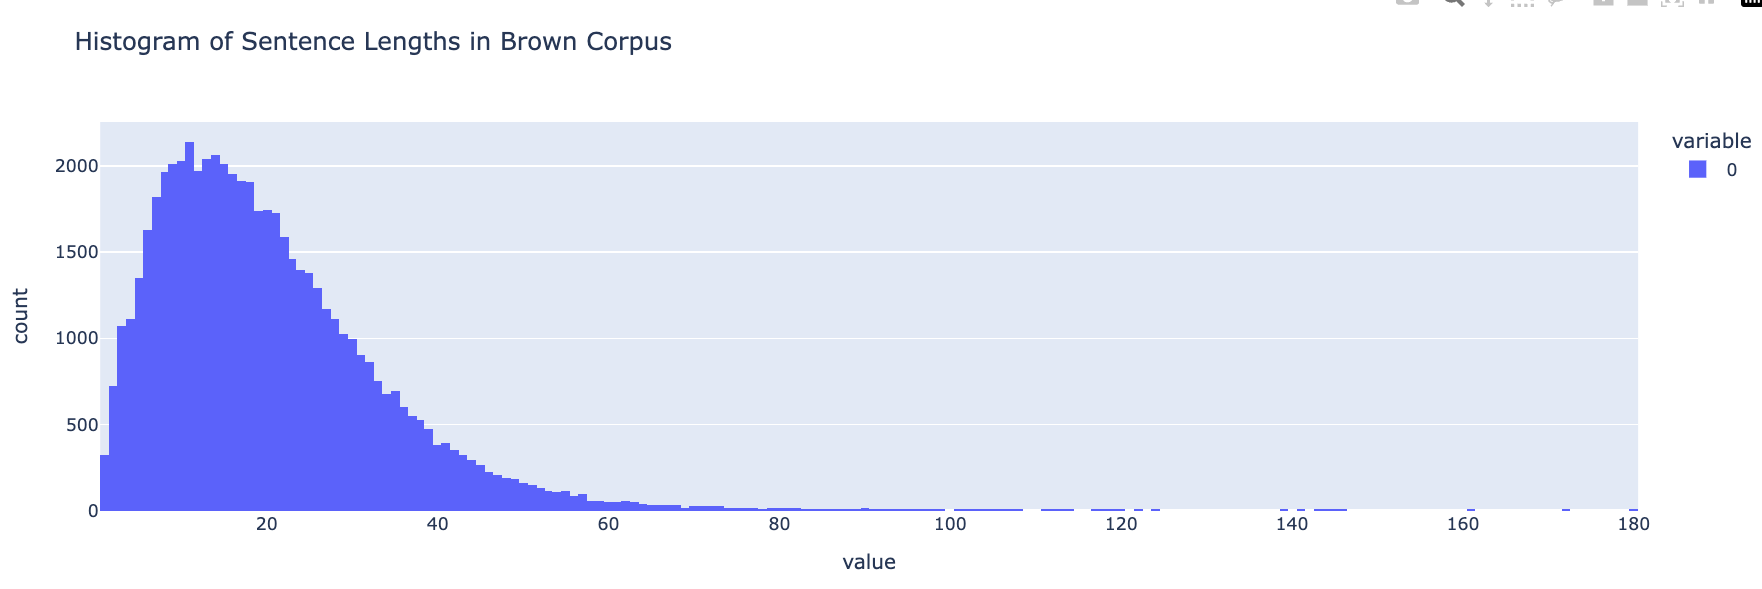

input context block : 4

Minimum sentence length: 5

### 2.1 Creating sentence split for train, test, validatiom

In [161]:
sentence_list_selected = [sent for sent in brown.sents() if len(sent) > 4]

In [162]:
random.shuffle(sentence_list_selected)
n1 = int(0.8 * len(sentence_list_selected))
n2 = int(0.9 *len(sentence_list_selected))

train_sentences = sentence_list_selected[:n1]
validation_sentences = sentence_list_selected[n1:n2]
test_sentences = sentence_list_selected[n2:]

### 2.1. Creating Train, Validation & Test Corpus

No Special Preprocessing is being applied except from case folding

In [131]:
training_corpus = {}

for sent in train_sentences:
    for word in sent:
        training_corpus[word] = training_corpus.get(word,0) + 1


In [163]:
print(f"Vocabulary size in Training Split: {len(training_corpus.items())}")

Vocabulary size in Training Split: 50113


### 2.2. Distribution of Tokens in Training Corpus

In [164]:
len(training_corpus.items())

50113

In [165]:
df_word_count = pd.DataFrame(data=sorted(training_corpus.items(), key= lambda kv: -kv[1]), columns=['Word', 'Count'])

In [166]:
px.histogram(df_word_count, x='Count', nbins=8000, title='Word Count Distribution in Training Split')

In [167]:
## based on paper, words appearing >= 3 times are considered as part of the vocabulary

vocab = [word for word, count in training_corpus.items() if count >= 5]

### 2.3. Creating encoder

In [194]:
vocabulary_cased = list(df_word_count['Word'].unique())
vocabulary = [word.lower() for word in vocabulary_cased]

#### 2.4. Understanding Presence of Special Characters

In [195]:
special_chars = set()
for word in vocabulary:
    special_chars.update(re.findall(r'[^a-zA-Z0-9]', word))

print("Unique special characters:", special_chars)

Unique special characters: {'$', ';', '}', '`', ',', '{', '[', '&', "'", '(', '*', '!', ')', '-', ':', ']', '/', '.', '?', '%', '+'}


In [196]:
def special_char_vocab(vocabulary: list[str], special_char: str) -> list[str]:
    return [word for word in vocabulary if special_char in word]

In [197]:
req_data = []
for char in special_chars:
    use_words = special_char_vocab(vocabulary, char)
    for word in use_words:
        req_data.append((char, word))

df_special_chars_use = pd.DataFrame(data=req_data, columns=['Special Character', 'Word'])

In [198]:
df_special_chars_use

,Special Character,Word
0,$,$1
1,$,$600
2,$,$500
3,$,$100
4,$,"$1,000"
...,...,...
8117,%,64%
8118,%,47.1%
8119,%,22%
8120,%,3.5%


In [199]:
df_word_count[df_word_count['Word'].isin(df_special_chars_use['Word'])].head(20)

,Word,Count
1,",",46643
2,.,38114
12,'',6967
13,``,6966
22,;,4400
27,?,3589
36,--,2727
50,(,1861
51,),1804
74,:,1296


In [205]:
encoder = {word: ix for ix, word in enumerate(vocabulary)}

_TOKEN_OOV_ = "<|UNK|>"

encoder[_TOKEN_OOV_] = len(encoder)

### 2.4. Creating Decoder

In [206]:
decoder = {ix: word for word, ix in encoder.items()}

### 2.5 Implementing Simple Tokeniser

Text is simply split by using space and special chars

In [224]:
class Tokenizer:
    _TOKEN_OOV_ = "<|UNK|>"

    def __init__(self, encoder: dict):
        self.str_to_int = encoder
        self.int_to_str = {i: s for s, i in encoder.items()}


    def encode(self, text_list: list[str]) -> list[int]:

        text_lower = [word.lower() for word in text_list if word.strip()] # case folding and removing spaces


        return [self.str_to_int.get(word, self.str_to_int[_TOKEN_OOV_]) for word in text_lower]
    
    def decode(self, text: list[int]) -> str:
        return ' '.join([self.int_to_str.get(ix) for ix in text]) # decoding


In [225]:
tokenizer = Tokenizer(encoder)

In [227]:
tokenizer.decode(tokenizer.encode(train_sentences[4]))

'a year later another salem ship returned from burma with a cargo of gum lacquer which nobody wanted to buy .'

In [217]:
text = "Do you know What is Mr.? It's 18:30."

tokenizer.decode(tokenizer.encode(text))

"do you know what is mr. ? it's 18 : 30 ."

### 3. Data set creation

In [244]:
random_sample_sentences = random.sample(train_sentences, 10)

In [240]:
req_list = []
for sentence_split in random_sample_sentences:
    length = len(sentence_split)
    for idx, token in enumerate(sentence_split):
        if token == ".":
            req_list.append((length -1, idx))

In [242]:
df_check = pd.DataFrame(data=req_list, columns=['Length', 'Index'])

In [251]:
context_size

4

In [272]:
## creating Train Set, for testing out 
x = []
y = []
for sentence_split in random_sample_sentences:
    k = 0
    for k in range(len(sentence_split) - context_size):
        context_broken_sent = sentence_split[k : k + context_size]
        output_token = sentence_split[k + context_size]
        x.append(tokenizer.encode(context_broken_sent))
        y.append(tokenizer.encode([output_token])[0])

In [273]:
context_broken_sent

['received', 'by', 'the', 'industry']

In [274]:
x

[[299, 20537, 1978, 597],
 [20537, 1978, 597, 6294],
 [1978, 597, 6294, 113],
 [597, 6294, 113, 8753],
 [6294, 113, 8753, 3300],
 [113, 8753, 3300, 15997],
 [8753, 3300, 15997, 219],
 [3300, 15997, 219, 6648],
 [15997, 219, 6648, 6746],
 [219, 6648, 6746, 17350],
 [6648, 6746, 17350, 390],
 [6746, 17350, 390, 15997],
 [17350, 390, 15997, 44766],
 [63, 16449, 1275, 1],
 [16449, 1275, 1, 14],
 [1275, 1, 14, 530],
 [1, 14, 530, 1021],
 [14, 530, 1021, 2405],
 [530, 1021, 2405, 15479],
 [1021, 2405, 15479, 219],
 [2405, 15479, 219, 3134],
 [15479, 219, 3134, 1978],
 [219, 3134, 1978, 14],
 [3134, 1978, 14, 13626],
 [1978, 14, 13626, 3288],
 [14, 13626, 3288, 39043],
 [13626, 3288, 39043, 113],
 [3288, 39043, 113, 14],
 [39043, 113, 14, 2750],
 [113, 14, 2750, 2228],
 [14, 2750, 2228, 864],
 [84, 10990, 419, 55],
 [10990, 419, 55, 3218],
 [419, 55, 3218, 45924],
 [55, 3218, 45924, 277],
 [3218, 45924, 277, 14],
 [45924, 277, 14, 19218],
 [277, 14, 19218, 31547],
 [14, 19218, 31547, 63],
 [1

In [275]:
y

[6294,
 113,
 8753,
 3300,
 15997,
 219,
 6648,
 6746,
 17350,
 390,
 15997,
 44766,
 2,
 14,
 530,
 1021,
 2405,
 15479,
 219,
 3134,
 1978,
 14,
 13626,
 3288,
 39043,
 113,
 14,
 2750,
 2228,
 864,
 2,
 3218,
 45924,
 277,
 14,
 19218,
 31547,
 63,
 15374,
 42796,
 12455,
 175,
 1810,
 3218,
 28248,
 286,
 14,
 15043,
 45925,
 2184,
 12724,
 1,
 14,
 3355,
 22690,
 2627,
 1270,
 27891,
 63,
 14,
 21674,
 45926,
 12300,
 22036,
 292,
 2616,
 2,
 14,
 24243,
 5241,
 1,
 2966,
 16659,
 4255,
 4476,
 235,
 14,
 10860,
 277,
 41,
 3218,
 6713,
 12148,
 159,
 14,
 3096,
 2858,
 2,
 1,
 458,
 7634,
 4312,
 3527,
 3527,
 440,
 3124,
 12568,
 113,
 42026,
 5567,
 286,
 36563,
 235,
 506,
 3969,
 8478,
 1,
 113,
 3527,
 717,
 3527,
 440,
 2741,
 8479,
 1279,
 898,
 219,
 1198,
 5103,
 113,
 3031,
 1,
 277,
 976,
 12568,
 113,
 4225,
 39462,
 3665,
 113,
 33144,
 12633,
 36,
 219,
 3300,
 5173,
 113,
 17102,
 9589,
 3878,
 34107,
 113,
 6930,
 340,
 6219,
 35782,
 38111,
 2,
 14,
 1907,
 219,


In [267]:
output_token

'accelerated'